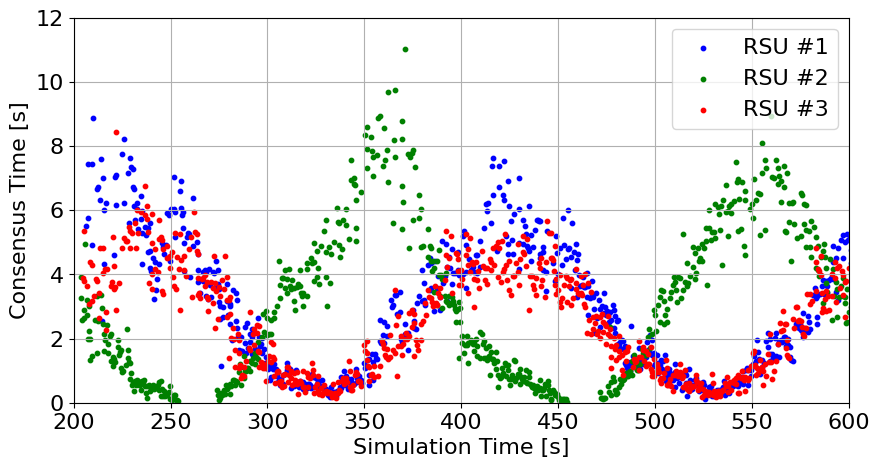

In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt


def get_consensus_time(input_folder_path):

    # CSVファイルの読み込み
    proposer_df = pd.read_csv(input_folder_path + "consensus_folder.csv")
    proposer_df = proposer_df.replace('null', pd.NA)

    # 結果を格納するリスト
    result = []
    simulation_buffer_time = 200
    simulation_start_time = 0
    simulation_time_list = []
    simulation_consensus_time_list = []

    # idごとに処理を行う
    for index, row in proposer_df.iterrows():
        if index == 0:
            simulation_start_time = int(row["start_time"])

        if pd.isna(row["end_time"]) or pd.isna(row["duration"]):
            continue  # Skip rows with NaN values
        
        simulation_now_time = (int(row["end_time"]) - simulation_start_time) / 1000 + simulation_buffer_time

        simulation_time_list.append(simulation_now_time)
        simulation_consensus_time_list.append(int(row["duration"]) / 1000)
    
    return simulation_time_list, simulation_consensus_time_list



# vehicle_speed_list = [40, 50, 60, 70, 80]
vehicle_speed = 70
min_vehicle_speed = 30
proposer_num = 3
validator_num = 250
participant_size = proposer_num + validator_num
message_size = 32
network_delay = 0
proposer_id_list = [0, 1, 2]
# proposer_id_list = [0, 1]

start_time_2lists = []
consensus_time_2lists = []


for proposer_id in proposer_id_list:
    input_folder_path = "../../results/multi_rsu_congestion/vs"  + str(vehicle_speed) + "_" + str(min_vehicle_speed) + "/n" + str(participant_size) + "/m" + str(message_size) + "/d" + str(network_delay) + "/" + str(proposer_id) + "/"
    # input_folder_path = "../../results/multi_rsu_congestion/vs70/n" + str(participant_size) + "/m" + str(message_size) + "/d" + str(network_delay) + "/" + str(proposer_id) + "/"
    start_time_list, consensus_time_list = get_consensus_time(input_folder_path)
    start_time_2lists.append(start_time_list)
    consensus_time_2lists.append(consensus_time_list)

# 3つwo1つのgraphにまとめる
plt.figure(figsize=(10, 5))
plt.scatter(start_time_2lists[0], consensus_time_2lists[0], c='blue', marker='o', s=10, label='RSU #1')
plt.scatter(start_time_2lists[1], consensus_time_2lists[1], c='green', marker='o', s=10, label='RSU #2')
plt.scatter(start_time_2lists[2], consensus_time_2lists[2], c='red', marker='o', s=10, label='RSU #3')
plt.xlabel('Simulation Time [s]', fontsize=16)
plt.ylabel('Consensus Time [s]', fontsize=16)

plt.ylim(0, 12)
plt.xlim(200, 600)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(True)
plt.legend(fontsize=16)
plt.show()

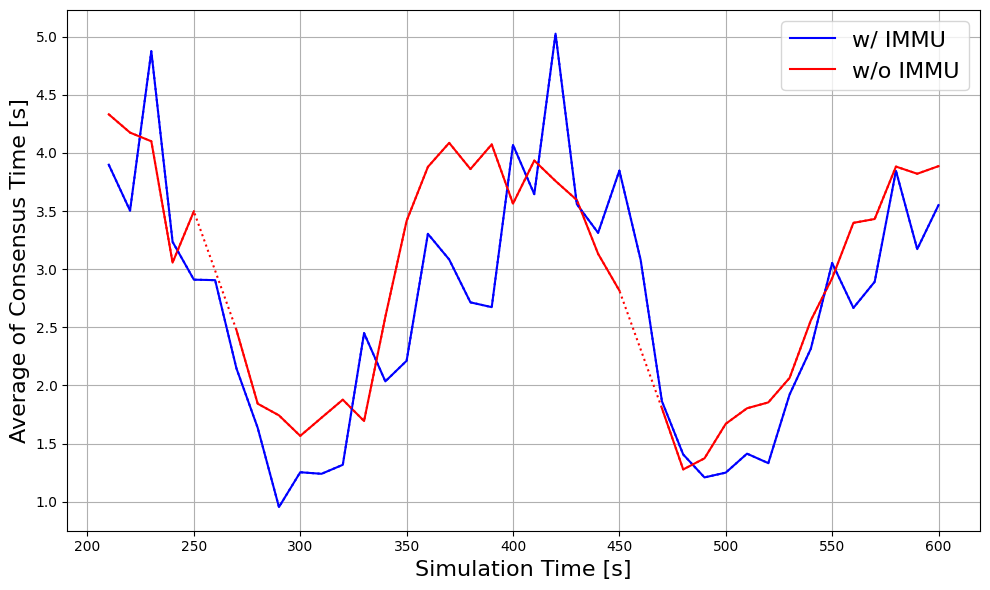

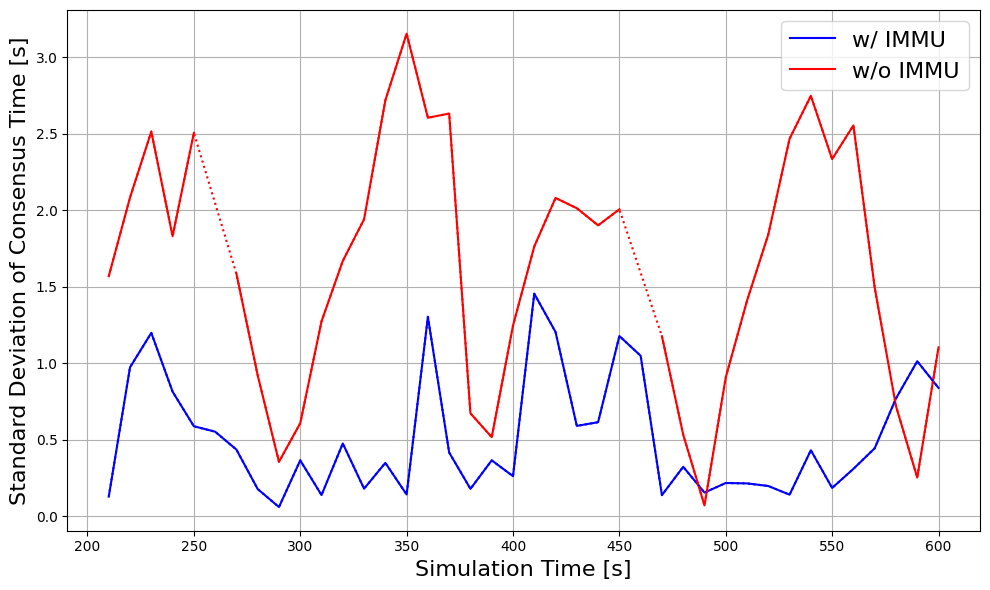

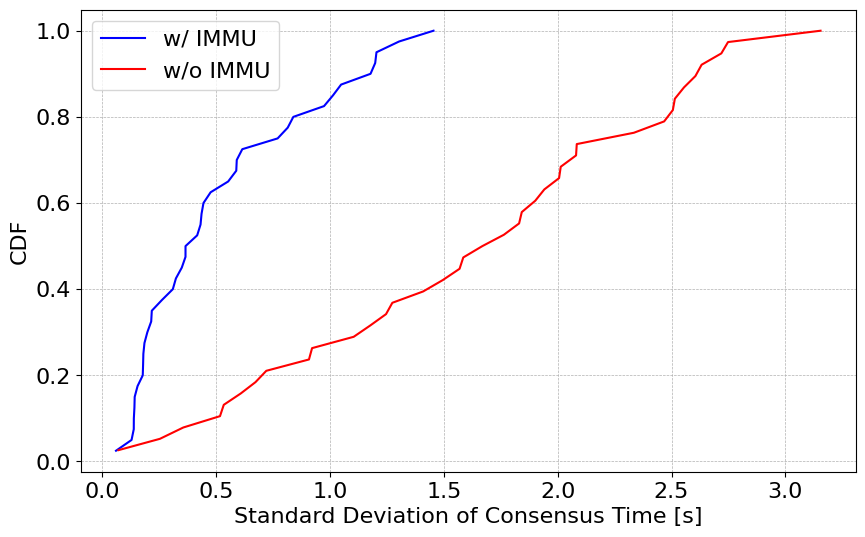

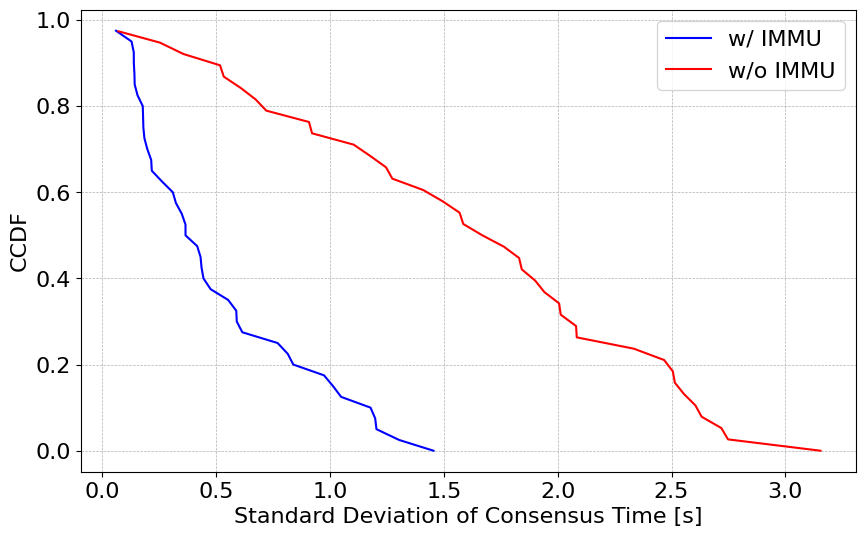

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def get_consensus_time(input_folder_path):
    # CSVファイルの読み込み
    proposer_df = pd.read_csv(input_folder_path + "consensus_folder.csv")
    proposer_df = proposer_df.replace('null', pd.NA)

    # 結果を格納するリスト
    simulation_buffer_time = 200
    simulation_start_time = 0
    simulation_time_list = []
    simulation_consensus_time_list = []

    # idごとに処理を行う
    for index, row in proposer_df.iterrows():
        if index == 0:
            simulation_start_time = int(row["start_time"])

        if pd.isna(row["end_time"]) or pd.isna(row["duration"]):
            continue  # Skip rows with NaN values
        
        simulation_now_time = (int(row["end_time"]) - simulation_start_time) / 1000 + simulation_buffer_time

        simulation_time_list.append(simulation_now_time)
        simulation_consensus_time_list.append(int(row["duration"]) / 1000)
    
    return simulation_time_list, simulation_consensus_time_list


def get_cdf_ccdf(data):
    # 有効なデータのみ取得（nanを除去）
    data = np.array(data)
    data = data[~np.isnan(data)]
    
    # CDFの計算
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    
    # CCDFの計算 (1 - CDF)
    ccdf = 1 - cdf
    
    return sorted_data, cdf, ccdf


# vehicle_speed_list = [40, 50, 60, 70, 80]
vehicle_speed = 70
min_vehicle_speed = 30
proposer_num = 3
validator_num = 250
participant_size = proposer_num + validator_num
message_size = 32
network_delay = 0
proposer_id_list = [0, 1, 2]

# 時間帯を10秒刻みで区切る
time_bins = np.arange(200, 601, 10)

# データを格納するためのリスト
averages_by_time_bin_1 = {proposer_id: [] for proposer_id in proposer_id_list}
averages_by_time_bin_2 = {proposer_id: [] for proposer_id in proposer_id_list}



# 各プロポーザーのstart_time_listとconsensus_time_listを取得
for proposer_id in proposer_id_list:
    # 1つ目のinput_folder_path
    input_folder_path_1 = "../../results/multi_rsu_congestion_with_immu/wd/vs70_30/n" + str(participant_size) + "/m" + str(message_size) + "/d" + str(network_delay) + "/" + str(proposer_id) + "/"
    start_time_list_1, consensus_time_list_1 = get_consensus_time(input_folder_path_1)

    # 2つ目のinput_folder_path
    input_folder_path_2 = "../../results/multi_rsu_congestion/vs70_30/n" + str(participant_size) + "/m" + str(message_size) + "/d" + str(network_delay) + "/" + str(proposer_id) + "/"
    start_time_list_2, consensus_time_list_2 = get_consensus_time(input_folder_path_2)

    # 10秒間隔での合意形成時間の平均を計算
    for time_bin in time_bins:
        consensus_times_in_bin_1 = []
        consensus_times_in_bin_2 = []

        # 1つ目のデータ
        for start_time, consensus_time in zip(start_time_list_1, consensus_time_list_1):
            if time_bin <= start_time < time_bin + 5:
                consensus_times_in_bin_1.append(consensus_time)
        
        # 2つ目のデータ
        for start_time, consensus_time in zip(start_time_list_2, consensus_time_list_2):
            if time_bin <= start_time < time_bin + 5:
                consensus_times_in_bin_2.append(consensus_time)

        # 平均をリストに追加
        if consensus_times_in_bin_1:
            averages_by_time_bin_1[proposer_id].append(np.mean(consensus_times_in_bin_1))
        else:
            averages_by_time_bin_1[proposer_id].append(np.nan)

        if consensus_times_in_bin_2:
            averages_by_time_bin_2[proposer_id].append(np.mean(consensus_times_in_bin_2))
        else:
            averages_by_time_bin_2[proposer_id].append(np.nan)



# 合意形成時間の平均のグラフも出す
averages_by_time_list_bin_1 = []
averages_by_time_list_bin_2 = []

for index in range(len(averages_by_time_bin_1[0])):
    consensus_average_time = 0
    for proposer_id in proposer_id_list:
        if averages_by_time_bin_1[proposer_id][index]:
            consensus_average_time += averages_by_time_bin_1[proposer_id][index]
        else:
            consensus_average_time =-1000
    
    if consensus_average_time > 0:
        averages_by_time_list_bin_1.append(consensus_average_time / len(proposer_id_list))
    else:
        averages_by_time_list_bin_1.append(np.nan)

for index in range(len(averages_by_time_bin_2[0])):
    consensus_average_time = 0
    for proposer_id in proposer_id_list:
        if averages_by_time_bin_1[proposer_id][index]:
            consensus_average_time += averages_by_time_bin_2[proposer_id][index]
        else:
            consensus_average_time =-1000
    
    if consensus_average_time > 0:
        averages_by_time_list_bin_2.append(consensus_average_time / len(proposer_id_list))
    else:
        averages_by_time_list_bin_2.append(np.nan)


# 補完処理: nanを線形補完
averages_by_time_list_bin_1_interp = pd.Series(averages_by_time_list_bin_1).interpolate().to_numpy()
averages_by_time_list_bin_2_interp = pd.Series(averages_by_time_list_bin_2).interpolate().to_numpy()

# プロット
plt.figure(figsize=(10, 6))

# 補完されていない部分を点線で表示
plt.plot(time_bins, averages_by_time_list_bin_1, label="w/ IMMU", color='blue')
plt.plot(time_bins, averages_by_time_list_bin_2, label="w/o IMMU", color='red')

# 補完後の部分を実線で表示
plt.plot(time_bins, averages_by_time_list_bin_1_interp, color='blue',  linestyle='dotted')
plt.plot(time_bins, averages_by_time_list_bin_2_interp, color='red',  linestyle='dotted')

plt.xlabel("Simulation Time [s]", fontsize=16)
plt.ylabel("Average of Consensus Time [s]", fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)

plt.tight_layout()
plt.show()


# proposer間の平均時間の標準偏差を算出
std_devs_by_time_bin_1 = []
std_devs_by_time_bin_2 = []

for i in range(len(time_bins)):
    # 1つ目のinput_folder_pathに基づく平均の標準偏差を計算
    time_bin_averages_1 = []
    for proposer_id in proposer_id_list:
        time_bin_averages_1.append(averages_by_time_bin_1[proposer_id][i])
    std_devs_by_time_bin_1.append(np.std(time_bin_averages_1))

    # 2つ目のinput_folder_pathに基づく平均の標準偏差を計算
    time_bin_averages_2 = []
    for proposer_id in proposer_id_list:
        time_bin_averages_2.append(averages_by_time_bin_2[proposer_id][i])
    std_devs_by_time_bin_2.append(np.std(time_bin_averages_2))

# 補完処理: nanを線形補完
std_devs_by_time_bin_1_interp = pd.Series(std_devs_by_time_bin_1).interpolate().to_numpy()
std_devs_by_time_bin_2_interp = pd.Series(std_devs_by_time_bin_2).interpolate().to_numpy()

# プロット
plt.figure(figsize=(10, 6))

# 補完されていない部分を点線で表示
plt.plot(time_bins, std_devs_by_time_bin_1, label="w/ IMMU", color='blue')
plt.plot(time_bins, std_devs_by_time_bin_2, label="w/o IMMU", color='red')

# 補完後の部分を実線で表示
plt.plot(time_bins, std_devs_by_time_bin_1_interp, color='blue',  linestyle='dotted')
plt.plot(time_bins, std_devs_by_time_bin_2_interp, color='red',  linestyle='dotted')

plt.xlabel("Simulation Time [s]", fontsize=16)
plt.ylabel("Standard Deviation of Consensus Time [s]", fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)

plt.tight_layout()
plt.show()




# CDFとCCDFの計算
sorted_data_1, cdf_1, ccdf_1 = get_cdf_ccdf(std_devs_by_time_bin_1)
sorted_data_2, cdf_2, ccdf_2 = get_cdf_ccdf(std_devs_by_time_bin_2)

# CDFのプロット
plt.figure(figsize=(10, 6))
# 縦軸を対数スケールに設定

plt.plot(sorted_data_1, cdf_1, label="w/ IMMU", color='blue')
plt.plot(sorted_data_2, cdf_2, label="w/o IMMU", color='red')
plt.xlabel("Standard Deviation of Consensus Time [s]", fontsize=16)
plt.ylabel("CDF", fontsize=16)
plt.legend(fontsize=16)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)  # 対数スケールで両方の目盛り線を表示
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

# CCDFのプロット
plt.figure(figsize=(10, 6))
# 縦軸を対数スケールに設定

plt.plot(sorted_data_1, ccdf_1, label="w/ IMMU", color='blue')
plt.plot(sorted_data_2, ccdf_2, label="w/o IMMU", color='red')
plt.xlabel("Standard Deviation of Consensus Time [s]", fontsize=16)
plt.ylabel("CCDF", fontsize=16)
plt.legend(fontsize=16)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)  # 対数スケールで両方の目盛り線を表示
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()


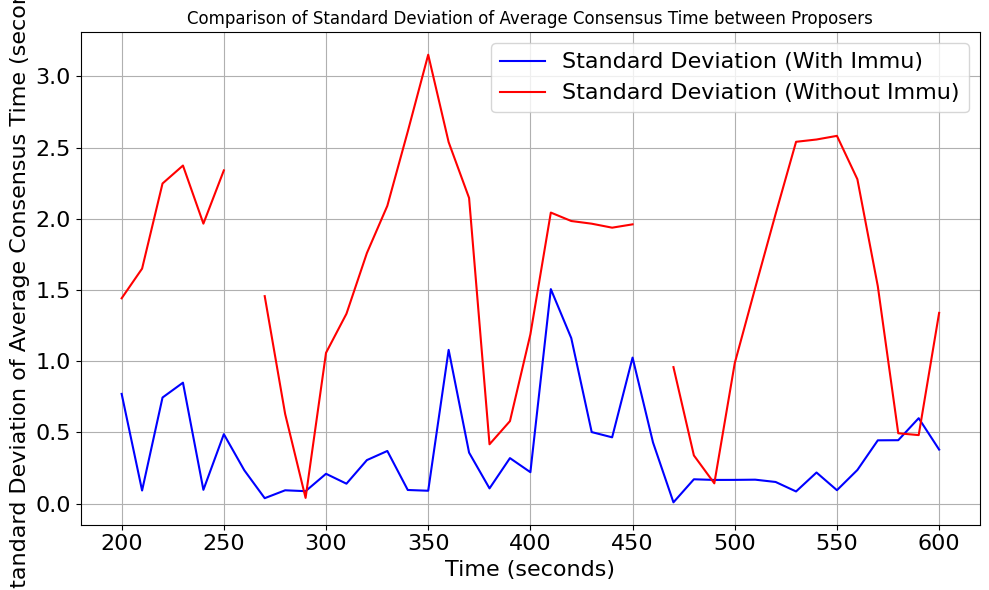